# Clasificador de Perros y Gatos

Este notebook implementa un modelo CNN para clasificar imágenes de perros y gatos.

In [1]:
# Importar librerías necesarias
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import kagglehub

c:\projects\python\clasificator-cat-dogs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Descargar y explorar el dataset

In [2]:
# Descargar dataset
path = kagglehub.dataset_download(
    "bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

data = Path(path)
print("Datos disponibles:", data)

Path to dataset files: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1
Datos disponibles: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


In [3]:
# Verificar archivos disponibles
image_files = list(data.glob('**/*.jpg'))
print(f"Total de imágenes encontradas: {len(image_files)}")
print("Ejemplos de rutas:", image_files[:5])

Total de imágenes encontradas: 24998
Ejemplos de rutas: [WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/0.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/1.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/10.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/100.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/1000.jpg')]


Ejemplo de gato: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Cat\10087.jpg
Ejemplo de perro: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\10087.jpg


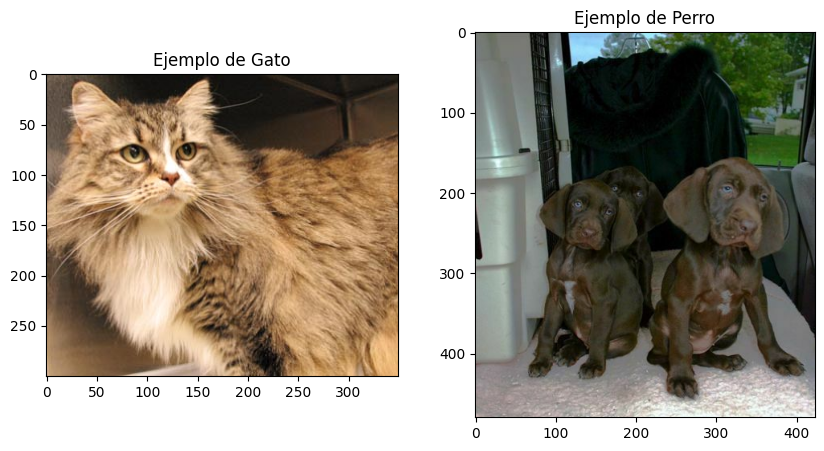

In [4]:
# Mostrar ejemplos de imágenes
try:
    cat_example = list(data.glob('PetImages/Cat/*.*'))[100]
    dog_example = list(data.glob('PetImages/Dog/*.*'))[100]
    print(f"Ejemplo de gato: {cat_example}")
    print(f"Ejemplo de perro: {dog_example}")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Ejemplo de Gato")
    plt.imshow(np.array(Image.open(str(cat_example))))
    
    plt.subplot(1, 2, 2)
    plt.title("Ejemplo de Perro")
    plt.imshow(np.array(Image.open(str(dog_example))))
    plt.show()
except Exception as e:
    print(f"Error al mostrar imágenes de ejemplo: {e}")

## Preparación de los datos

In [5]:
# Preparar los datos
animals = {
    'dog': list(data.glob('PetImages/Dog/*.*')),
    'cat': list(data.glob('PetImages/Cat/*.*')),
}

label = {
    'dog': 1,
    'cat': 0,
}

print(f"Imágenes de perro: {len(animals['dog'])}")
print(f"Imágenes de gato: {len(animals['cat'])}")

Imágenes de perro: 12499
Imágenes de gato: 12499


In [10]:
# Función de preprocesamiento de imágenes
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        # Convertir de BGR a RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Redimensionar
        img_resized = cv2.resize(img, target_size)
        
        # Normalizar
        img_normalized = img_resized / 255.0
        
        return (img_normalized.astype(np.float32))
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

In [11]:
# Cargar imágenes con barra de progreso
X = []
Y = []
total_images = sum(len(images) for images in animals.values())
processed = 0
print(f"Procesando {total_images} imágenes...")

for name, images in animals.items():
    for image in images:
        processed += 1
        if processed % 1000 == 0:
            print(f"Procesadas {processed}/{total_images} imágenes")
            
        image_path = str(image).strip()
        img_processed = load_and_preprocess_image(image_path)
        
        if img_processed is not None:
            X.append(img_processed)
            Y.append(label[name])

print(f"Imágenes cargadas correctamente: {len(X)} de {total_images}")

Procesando 24998 imágenes...
Procesadas 1000/24998 imágenes
Procesadas 2000/24998 imágenes
Procesadas 3000/24998 imágenes
Procesadas 4000/24998 imágenes
Procesadas 5000/24998 imágenes
Procesadas 6000/24998 imágenes
Procesadas 7000/24998 imágenes
Procesadas 8000/24998 imágenes
Procesadas 9000/24998 imágenes
Procesadas 10000/24998 imágenes
Procesadas 11000/24998 imágenes
Procesadas 12000/24998 imágenes
Procesadas 13000/24998 imágenes
Procesadas 14000/24998 imágenes
Procesadas 15000/24998 imágenes
Procesadas 16000/24998 imágenes
Procesadas 17000/24998 imágenes
Procesadas 18000/24998 imágenes
Procesadas 19000/24998 imágenes
Procesadas 20000/24998 imágenes
Procesadas 21000/24998 imágenes
Procesadas 22000/24998 imágenes
Procesadas 23000/24998 imágenes
Procesadas 24000/24998 imágenes
Imágenes cargadas correctamente: 24946 de 24998


In [12]:
# Convertir a arrays de NumPy
X = np.array(X)
Y = np.array(Y)

print(f"Forma del conjunto de datos: {X.shape}")
print(f"Distribución de clases: {np.bincount(Y)}")

Forma del conjunto de datos: (24946, 150, 150, 3)
Distribución de clases: [12476 12470]


## División de los datos y creación del modelo

In [13]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (19956, 150, 150, 3), (19956,)
Conjunto de prueba: (4990, 150, 150, 3), (4990,)


In [14]:
# Definir aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [16]:
# Construir un modelo mejorado
def build_model(input_shape=(150, 150, 3)):
    model = Sequential([
        # Capa de aumentación de datos
        data_augmentation,
        
        # Primera capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Segunda capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Tercera capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Cuarta capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Aplanar y capas densas
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Crear y mostrar resumen del modelo
model = build_model(input_shape=X_train[0].shape)
model.summary()

c:\projects\python\clasificator-cat-dogs\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [18]:
# Callbacks para mejorar el entrenamiento
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, monitor='val_loss')
]

In [20]:
# Entrenar modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.5535 - loss: 1.2165 - val_accuracy: 0.6408 - val_loss: 0.7689 - learning_rate: 1.0000e-04
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 131s 263ms/step - accuracy: 0.6666 - loss: 0.7263 - val_accuracy: 0.7179 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.7084 - loss: 0.6352 - val_accuracy: 0.7497 - val_loss: 0.5736 - learning_rate: 1.0000e-04
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 155s 292ms/step - accuracy: 0.7230 - loss: 0.6007 - val_accuracy: 0.7485 - val_loss: 0.5520 - learning_rate: 1.0000e-04
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 148s 296ms/step - accuracy: 0.7311 - loss: 0.5769 - val_accuracy: 0.7695 - val_loss: 0.5216 - learning_rate: 1.0000e-04


## Evaluación del modelo

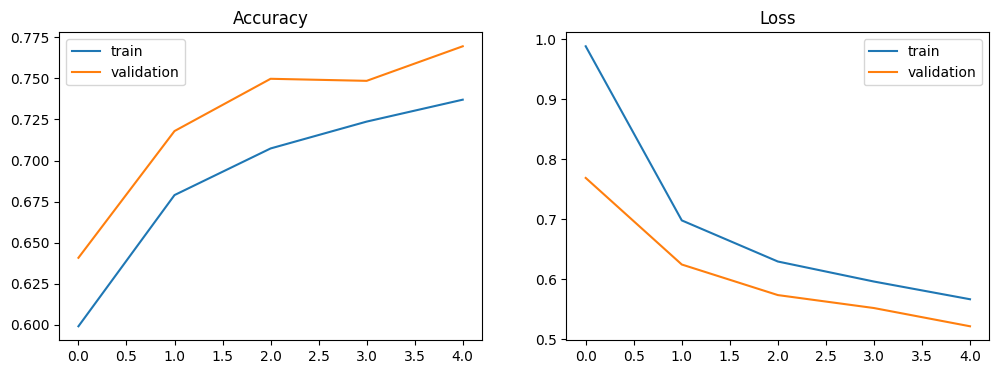

In [21]:
# Visualizar curvas de aprendizaje
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.show()

In [22]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7645 - loss: 0.5248
Precisión en el conjunto de prueba: 0.7715


In [23]:
# Guardar el modelo
model.save('models/cat_dog_classifier_improved.h5')
print("Modelo guardado correctamente")

Modelo guardado correctamente


## Predicciones con el modelo

In [24]:
# Función para predicción de imágenes
def predict_image(image_path, model):
    img = load_and_preprocess_image(image_path)
    if img is None:
        return "No se pudo cargar la imagen"
    
    # Agregar dimensión de batch
    img = np.expand_dims(img, axis=0)
    
    # Predecir
    prediction = model.predict(img)[0][0]
    class_name = "Perro" if prediction > 0.5 else "Gato"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return f"Clase: {class_name}, Confianza: {confidence:.2f}"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Imagen: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\460.jpg, Predicción: Clase: Perro, Confianza: 0.94


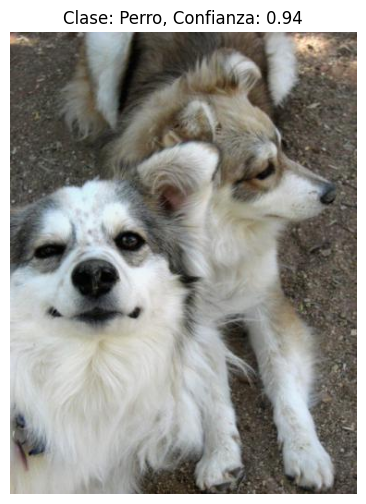

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Imagen: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\4600.jpg, Predicción: Clase: Perro, Confianza: 0.89


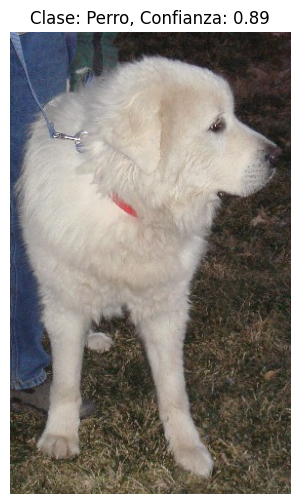

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Imagen: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\4601.jpg, Predicción: Clase: Perro, Confianza: 0.52


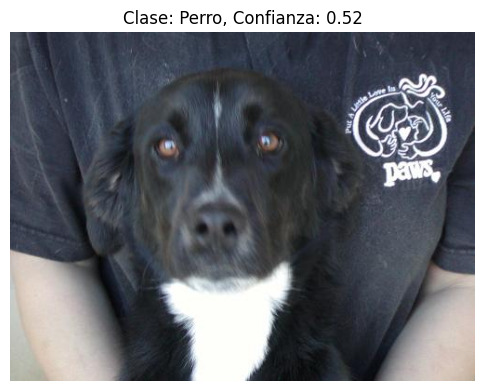

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Imagen: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\4602.jpg, Predicción: Clase: Perro, Confianza: 0.90


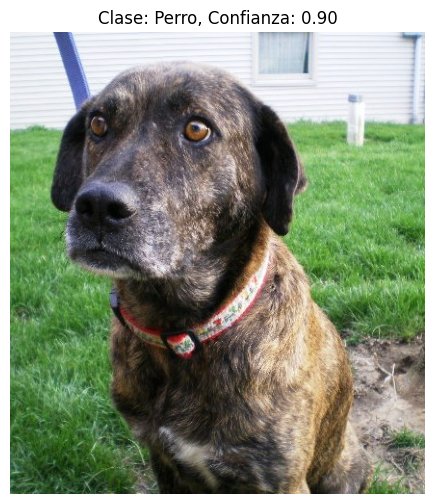

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Imagen: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\4603.jpg, Predicción: Clase: Gato, Confianza: 0.62


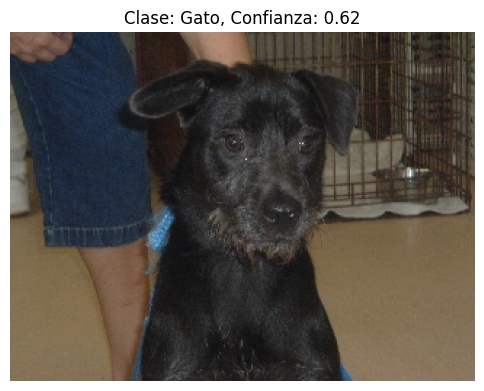

In [29]:
# Probar predicciones con algunas imágenes
test_images = image_files[19000:19005]
for img_path in test_images:
    result = predict_image(str(img_path), model)
    print(f"Imagen: {img_path}, Predicción: {result}")
    
    # Mostrar la imagen con su predicción
    img = Image.open(str(img_path))
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(img))
    plt.title(result)
    plt.axis('off')
    plt.show()

## Conclusión

El modelo mejorado de clasificación de perros y gatos debería obtener una precisión significativamente mayor que el modelo original. Las principales mejoras incluyen:

1. Preprocesamiento adecuado de las imágenes
2. Normalización de los datos
3. Arquitectura CNN más profunda
4. Aumento de datos para mejorar la generalización
5. Ajuste de hiperparámetros (tasa de aprendizaje, regularización)
6. Uso de callbacks para controlar el entrenamiento